same effect as a nested resampling?

In [28]:
%qtconsole
%matplotlib inline

In [142]:
# external packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# some functions
def ts2df(ts, n_lags):
    #############################################
    ###
    #
    #
    #############################################

    # mount dataframe
    for i in range(n_lags+1):
        if i==0:
            df = ts
        else:
            df = pd.concat([df, ts.shift(i)], axis=1)

    # separate input from output
    df = df.dropna()
    df.columns = ["lag_" + str(s) for s in range(n_lags+1)]

    # output
    return df

# Reproducing Paper Results - No signal at all

https://papers.nips.cc/paper/5993-generalization-in-adaptive-data-analysis-and-holdout-reuse.pdf

https://github.com/andyljones/thresholdout/blob/master/thresholdout.py

http://science.sciencemag.org/content/suppl/2015/08/05/349.6248.636.DC1/Dwork.SM.pdf

## Parameters

In [15]:
n = 10000 # number of samples
d = 10000 # number of available features
p1 = 0.5 # frequency class 1
h = 0.5 # holdout ratio
var_set = range(1, 500)[::20] # top k variables
num_exp = 100 # number of experiments
T = 0.02 # Thresholdout parameter
tolerance = 0.01 # std gaussian noise
gen_error = 0.1
B = int(gen_error*n) # http://andyljones.tumblr.com/post/127547085623/holdout-reuse

## Simulation

In [16]:
# pre-allocation
acc_trad = pd.DataFrame(index=[0], columns=["exp", "train", "test", "fresh"])
acc_thresh = pd.DataFrame(index=[0], columns=["exp", "train", "test", "fresh"])
B = 0

# initial data
df = pd.DataFrame(np.random.normal(size=(n, d)))
df["out"] = 1.0
df.loc[:int(n*p1), "out"] = 1.0
df.loc[int(n*p1):, "out"] = -1.0
df = df.sample(n=n).copy()
df.index = list(range(n))

# fresh data
df_fresh = pd.DataFrame(np.random.normal(size=(int(n*h), d)))
df_fresh["out"] = 1.0
df_fresh.loc[:int(n*p1), "out"] = 1.0
df_fresh.loc[int(n*p1):, "out"] = -1.0
df_fresh = df_fresh.sample(n=int(n*h)).copy()
df_fresh.index = list(range(int(n*h)))

# classification for every feature set
g, u = 0, 0
for exp in range(num_exp):
    
    # split in training and test
    df = df.sample(n=n)#.copy()
    df.index = list(range(n))
    df_tr = df.loc[:int(n*h)]#.copy()
    df_ts = df.loc[int(n*h):]#.copy()
    df_ts.index = list(range(len(df_ts)))

    # correlation
    corr_tr = df_tr.drop("out", axis=1).corrwith(df_tr["out"])
    corr_ts = df_ts.drop("out", axis=1).corrwith(df_ts["out"])
    
    # order features
    W = corr_tr[(corr_tr*corr_ts > 0) & (corr_tr.abs() >= 1.0/np.sqrt(n)) & (corr_ts.abs() >= 1.0/np.sqrt(n))]
    V = list(W.abs().sort_values(ascending=False).index)
    
    # traditional and blind approach
    for k in var_set:

        # variable set
        Vk = V[:k] # vars to be used

        # construct the classifier
        pred_tr = np.sign((df_tr[Vk]*np.sign(W[Vk])).sum(axis=1))
        pred_ts = np.sign((df_ts[Vk]*np.sign(W[Vk])).sum(axis=1))
        pred_fresh = np.sign((df_fresh[Vk]*np.sign(W[Vk])).sum(axis=1))

        # evalute the classifier in the different sets
        acc_trad.loc[g, "vars"] = len(Vk)
        acc_trad.loc[g, "train"] = (pred_tr==df_tr["out"]).mean()
        acc_trad.loc[g, "test"] = (pred_ts==df_ts["out"]).mean()
        acc_trad.loc[g, "fresh"] = (pred_fresh==df_fresh["out"]).mean()
        acc_trad.loc[g, "exp"]  = exp
        g+=1
        
    # order features
#    for v in range(d):
#        if np.abs(corr_tr[v] - corr_ts[v]) > T + np.random.normal(0, tolerance):
#            corr_ts[v] += np.random.normal(0,tolerance)
#        else:
#            corr_ts[v] = corr_tr[v]
    
    diffs = np.abs(corr_tr - corr_ts)
    noise = np.random.normal(0, tolerance, d) # vectorising a loop
    abovethr = diffs > T + noise # vectorising a loop
    corr_ts.loc[~abovethr] = corr_tr.loc[~abovethr] # if not above thresh, receive train estimate
    corr_ts.loc[abovethr] = (corr_ts+np.random.normal(0,tolerance,d)).loc[abovethr] # otherwise, get holdout + noise
    W = corr_tr[(corr_tr*corr_ts > 0) & (corr_tr.abs() >= 1.0/np.sqrt(n)) & (corr_ts.abs() >= 1.0/np.sqrt(n))]
    V = list(W.abs().sort_values(ascending=False).index)
    
    # thresholdout
    for k in var_set:
        
        # variable set
        Vk = V[:k] # vars to be used

        # construct the classifier
        pred_tr = np.sign((df_tr[Vk]*np.sign(W[Vk])).sum(axis=1))
        pred_ts = np.sign((df_ts[Vk]*np.sign(W[Vk])).sum(axis=1))
        pred_fresh = np.sign((df_fresh[Vk]*np.sign(W[Vk])).sum(axis=1))
        
        # evalute the classifier in the different sets
        acc_thresh.loc[u, "vars"] = len(Vk)
        acc_thresh.loc[u, "train"] = (pred_tr==df_tr["out"]).mean()
        acc_thresh.loc[u, "test"] = (pred_ts==df_ts["out"]).mean()
        acc_thresh.loc[u, "fresh"] = (pred_fresh==df_fresh["out"]).mean()
        acc_thresh.loc[u, "exp"]  = exp
    
        # thresholdout criteria
        if abs(acc_thresh.loc[u, "train"]-acc_thresh.loc[u, "test"]) < T + np.random.normal(0, tolerance):
            acc_thresh.loc[u, "test"] = acc_thresh.loc[u, "train"]
        else:
            acc_thresh.loc[u, "test"] += np.random.normal(0,tolerance)
            B+=1
        u+=1

# final organisation
acc_thresh = acc_thresh.apply(pd.to_numeric, errors='ignore', axis=1)
acc_trad = acc_trad.apply(pd.to_numeric, errors='ignore', axis=1)

## Charts

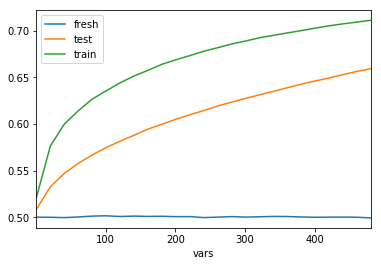

In [17]:
acc_trad.pivot_table(index="vars").drop("exp", axis=1).plot()

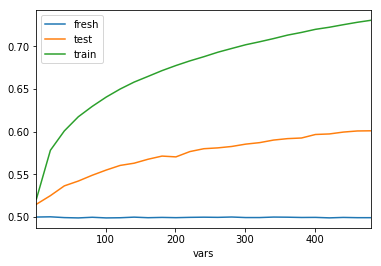

In [18]:
acc_thresh.pivot_table(index="vars").drop("exp", axis=1).plot()

# Reproducing another paper - With some signal

http://www.win-vector.com/blog/2015/10/a-simpler-explanation-of-differential-privacy/

## Parameters

In [282]:
n = 2000 # number of samples
dsignal = 10 # number of features linked with the labels
feat_noise = 0.90 # noise after signal
drandom = 100 # number of available randomly generated features
d = dsignal + drandom # number of available features
p1 = 0.5 # frequency class 1 - does not work
h = 0.5 # holdout ratio
iterations = 50 # number of iterations for forward selection
num_exp = 3 # number of experiments
T = 0.08 # Thresholdout parameter
tolerance = 0.01 # std gaussian noise
gen_error = 0.1 # generalisation error spread
B = int(gen_error*n) # budget - http://andyljones.tumblr.com/post/127547085623/holdout-reuse

## Simulation

In [251]:
from sklearn.linear_model import LogisticRegression

# pre-allocation
acc_trad = pd.DataFrame(index=[0], columns=["iter", "exp", "train", "test", "fresh"])
acc_thresh = pd.DataFrame(index=[0], columns=["iter", "exp", "train", "test", "fresh"])

# initial data
df = pd.DataFrame(np.random.normal(size=(n, d)))
df["out"] = df[list(range(dsignal))].mean(axis=1) + np.random.normal(scale=feat_noise, size=n)
df.loc[df["out"] > 0.0, "out"] = 1.0
df.loc[df["out"] < 0.0, "out"] = -1.0
df = df.sample(n=n).copy()
df.index = list(range(n))

# fresh data
df_fresh = pd.DataFrame(np.random.normal(size=(int(n*h), d)))
df_fresh["out"] = df_fresh[list(range(dsignal))].mean(axis=1) + np.random.normal(scale=feat_noise, size=int(n*h))
df_fresh.loc[df_fresh["out"] > 0.0, "out"] = 1.0
df_fresh.loc[df_fresh["out"] < 0.0, "out"] = -1.0
df_fresh = df_fresh.sample(n=int(n*h)).copy()
df_fresh.index = list(range(int(n*h)))

# classification for every feature set
g, u = 0, 0
for exp in range(num_exp):
    
    # split in training and test
    df = df.sample(n=n)
    df.index = list(range(n))
    poslabel, neglabel = np.array(df["out"] == 1.0).tolist(), np.array(df["out"] == -1.0).tolist()
    poslabel, neglabel = [i for i, x in enumerate(poslabel) if x], [i for i, x in enumerate(neglabel) if x]
    df_tr = df.loc[poslabel[:int(len(poslabel)/2.0)] + neglabel[:int(len(neglabel)/2.0)]]
    df_tr.index = list(range(len(df_tr)))
    df_ts = df.loc[poslabel[int(len(poslabel)/2.0):] + neglabel[int(len(neglabel)/2.0):]]
    df_ts.index = list(range(len(df_ts)))
       
    # traditional and blind approach
    iter_end_fmask, end_fmask, iter_fmask, fset = [], [], [], list(df.drop("out", axis=1).columns)
    for k in range(iterations): # number of iterations for feature selection

        # variable set
        test_acc = []
        for f in fset:
            # train model
            iter_fmask = end_fmask + [f]
            ml = LogisticRegression(C=10000.0).fit(df_tr[iter_fmask], df_tr["out"])

            # prediction and accuracy
            test_acc.append((ml.predict(df_ts[iter_fmask])==df_ts["out"]).mean())
            
        # pick best feature test set
        end_fmask = end_fmask + [fset[np.argmax(np.array(test_acc))]]
        fset.remove(fset[np.argmax(np.array(test_acc))])
        
        # final prediction and accuracy
        ml = LogisticRegression(C=10000.0).fit(df_tr[end_fmask], df_tr["out"])
        pred_tr = ml.predict(df_tr[end_fmask])
        pred_ts = ml.predict(df_ts[end_fmask])
        pred_fresh = ml.predict(df_fresh[end_fmask])

        # evalute the classifier in the different sets
        acc_trad.loc[g, "iter"] = k
        acc_trad.loc[g, "nvars"] = len(end_fmask)
        acc_trad.loc[g, "train"] = (pred_tr==df_tr["out"]).mean()
        acc_trad.loc[g, "test"] = (pred_ts==df_ts["out"]).mean()
        acc_trad.loc[g, "fresh"] = (pred_fresh==df_fresh["out"]).mean()
        acc_trad.loc[g, "exp"]  = exp
        iter_end_fmask.append(end_fmask)
        g+=1
        
    
    # thresholdout
    thresh_iter_end_fmask, end_fmask, iter_fmask, fset = [], [], [], list(df.drop("out", axis=1).columns)
    for k in range(iterations): # number of iterations for feature selection

        # variable set
        test_acc = []
        for f in fset:
            
            # train model
            iter_fmask = end_fmask + [f]
            ml = LogisticRegression(C=10000.0).fit(df_tr[iter_fmask], df_tr["out"])

            # prediction and accuracy
            tr_acc = (ml.predict(df_tr[iter_fmask])==df_tr["out"]).mean()
            ts_acc = (ml.predict(df_ts[iter_fmask])==df_ts["out"]).mean()
            
            # thresholdout criteria
            if abs(tr_acc-ts_acc) < T + np.random.normal(0, tolerance):
                ts_acc = tr_acc
            else:
                ts_acc += np.random.normal(0,tolerance)
            test_acc.append(ts_acc)
            
        # pick best feature test set
        end_fmask = end_fmask + [fset[np.argmax(np.array(test_acc))]]
        fset.remove(fset[np.argmax(np.array(test_acc))])
        
        # final prediction and accuracy
        ml = LogisticRegression(C=10000.0).fit(df_tr[end_fmask], df_tr["out"])
        pred_tr = ml.predict(df_tr[end_fmask])
        pred_ts = ml.predict(df_ts[end_fmask])
        pred_fresh = ml.predict(df_fresh[end_fmask])

        # evalute the classifier in the different sets
        acc_thresh.loc[u, "iter"] = k
        acc_thresh.loc[u, "nvars"] = len(end_fmask)
        acc_thresh.loc[u, "train"] = (pred_tr==df_tr["out"]).mean()
        acc_thresh.loc[u, "test"] = (pred_ts==df_ts["out"]).mean()
        acc_thresh.loc[u, "fresh"] = (pred_fresh==df_fresh["out"]).mean()
        acc_thresh.loc[u, "exp"]  = exp
        thresh_iter_end_fmask.append(end_fmask)
        u+=1
        
# final organisation
acc_thresh = acc_thresh.apply(pd.to_numeric, errors='ignore', axis=1)
acc_trad = acc_trad.apply(pd.to_numeric, errors='ignore', axis=1)

## Charts

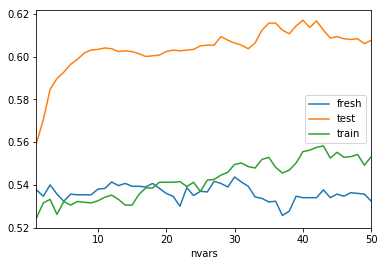

In [252]:
acc_trad.pivot_table(index="nvars").drop(["exp", "iter"], axis=1).plot()

In [253]:
iter_end_fmask

[[4],
 [4, 3],
 [4, 3, 62],
 [4, 3, 62, 73],
 [4, 3, 62, 73, 44],
 [4, 3, 62, 73, 44, 90],
 [4, 3, 62, 73, 44, 90, 35],
 [4, 3, 62, 73, 44, 90, 35, 17],
 [4, 3, 62, 73, 44, 90, 35, 17, 43],
 [4, 3, 62, 73, 44, 90, 35, 17, 43, 87],
 [4, 3, 62, 73, 44, 90, 35, 17, 43, 87, 22],
 [4, 3, 62, 73, 44, 90, 35, 17, 43, 87, 22, 56],
 [4, 3, 62, 73, 44, 90, 35, 17, 43, 87, 22, 56, 24],
 [4, 3, 62, 73, 44, 90, 35, 17, 43, 87, 22, 56, 24, 77],
 [4, 3, 62, 73, 44, 90, 35, 17, 43, 87, 22, 56, 24, 77, 25],
 [4, 3, 62, 73, 44, 90, 35, 17, 43, 87, 22, 56, 24, 77, 25, 81],
 [4, 3, 62, 73, 44, 90, 35, 17, 43, 87, 22, 56, 24, 77, 25, 81, 109],
 [4, 3, 62, 73, 44, 90, 35, 17, 43, 87, 22, 56, 24, 77, 25, 81, 109, 82],
 [4, 3, 62, 73, 44, 90, 35, 17, 43, 87, 22, 56, 24, 77, 25, 81, 109, 82, 51],
 [4,
  3,
  62,
  73,
  44,
  90,
  35,
  17,
  43,
  87,
  22,
  56,
  24,
  77,
  25,
  81,
  109,
  82,
  51,
  79],
 [4,
  3,
  62,
  73,
  44,
  90,
  35,
  17,
  43,
  87,
  22,
  56,
  24,
  77,
  25,
  81,
  1

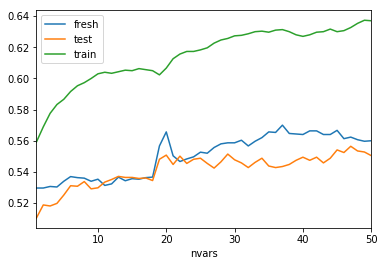

In [254]:
acc_thresh.pivot_table(index="nvars").drop(["exp", "iter"], axis=1).plot()

In [255]:
thresh_iter_end_fmask

[[64],
 [64, 89],
 [64, 89, 17],
 [64, 89, 17, 87],
 [64, 89, 17, 87, 22],
 [64, 89, 17, 87, 22, 35],
 [64, 89, 17, 87, 22, 35, 43],
 [64, 89, 17, 87, 22, 35, 43, 77],
 [64, 89, 17, 87, 22, 35, 43, 77, 51],
 [64, 89, 17, 87, 22, 35, 43, 77, 51, 109],
 [64, 89, 17, 87, 22, 35, 43, 77, 51, 109, 24],
 [64, 89, 17, 87, 22, 35, 43, 77, 51, 109, 24, 38],
 [64, 89, 17, 87, 22, 35, 43, 77, 51, 109, 24, 38, 29],
 [64, 89, 17, 87, 22, 35, 43, 77, 51, 109, 24, 38, 29, 82],
 [64, 89, 17, 87, 22, 35, 43, 77, 51, 109, 24, 38, 29, 82, 34],
 [64, 89, 17, 87, 22, 35, 43, 77, 51, 109, 24, 38, 29, 82, 34, 79],
 [64, 89, 17, 87, 22, 35, 43, 77, 51, 109, 24, 38, 29, 82, 34, 79, 56],
 [64, 89, 17, 87, 22, 35, 43, 77, 51, 109, 24, 38, 29, 82, 34, 79, 56, 57],
 [64, 89, 17, 87, 22, 35, 43, 77, 51, 109, 24, 38, 29, 82, 34, 79, 56, 57, 5],
 [64,
  89,
  17,
  87,
  22,
  35,
  43,
  77,
  51,
  109,
  24,
  38,
  29,
  82,
  34,
  79,
  56,
  57,
  5,
  2],
 [64,
  89,
  17,
  87,
  22,
  35,
  43,
  77,
  51,


# Applying it to real data - Feature Selection

## Parameters

In [256]:
data_path = "SPX Index.csv" # data path
lags = 126 # number of lags to be considered
hold = 0.3 # holdout ratio
fresh = 0.3 # fresh ratio
iterations = 80 # number of iterations for forward selection
num_exp = 10 # number of experiments
T = 0.04 # Thresholdout parameter
tolerance = 0.01 # std gaussian noise
gen_error = 0.1 # generalisation error spread
B = int(gen_error*n) # budget - http://andyljones.tumblr.com/post/127547085623/holdout-reuse

In [ ]:
tr1, ts1, fr1, tr2, ts2, fr2, ...

## Simulation

In [257]:
from sklearn.linear_model import LogisticRegression

# pre-allocation
acc_trad = pd.DataFrame(index=[0], columns=["iter", "exp", "train", "test", "fresh"])
acc_thresh = pd.DataFrame(index=[0], columns=["iter", "exp", "train", "test", "fresh"])

# initial data to train, test and fresh
df = pd.read_csv(data_path, index_col=0)
df = ts2df(df, lags)
df.loc[df["lag_0"] > 0, "lag_0"] = 1.0
df.loc[df["lag_0"] <= 0, "lag_0"] = -1.0
df_tr = df.iloc[]
#df_tr = df.iloc[:(len(df)-int(len(df)*(fresh+hold)))]
#df_ts = df.iloc[(len(df)-int(len(df)*(fresh+hold))):(len(df)-int(len(df)*fresh))]
#df_fresh = df.iloc[(len(df)-int(len(df)*fresh)):]

# classification for every feature set
g, u = 0, 0
for exp in range(num_exp):
       
    # traditional and blind approach
    iter_end_fmask, end_fmask, iter_fmask, fset = [], [], [], list(df.drop("lag_0", axis=1).columns)
    for k in range(iterations): # number of iterations for feature selection

        # variable set
        test_acc = []
        for f in fset:
            # train model
            iter_fmask = end_fmask + [f]
            ml = LogisticRegression(C=10000.0).fit(df_tr[iter_fmask], df_tr["lag_0"])

            # prediction and accuracy
            test_acc.append((ml.predict(df_ts[iter_fmask])==df_ts["lag_0"]).mean())
            
        # pick best feature test set
        end_fmask = end_fmask + [fset[np.argmax(np.array(test_acc))]]
        fset.remove(fset[np.argmax(np.array(test_acc))])
        
        # final prediction and accuracy
        ml = LogisticRegression(C=10000.0).fit(df_tr[end_fmask], df_tr["lag_0"])
        pred_tr = ml.predict(df_tr[end_fmask])
        pred_ts = ml.predict(df_ts[end_fmask])
        pred_fresh = ml.predict(df_fresh[end_fmask])

        # evalute the classifier in the different sets
        acc_trad.loc[g, "iter"] = k
        acc_trad.loc[g, "nvars"] = len(end_fmask)
        acc_trad.loc[g, "train"] = (pred_tr==df_tr["lag_0"]).mean()
        acc_trad.loc[g, "test"] = (pred_ts==df_ts["lag_0"]).mean()
        acc_trad.loc[g, "fresh"] = (pred_fresh==df_fresh["lag_0"]).mean()
        acc_trad.loc[g, "exp"]  = exp
        iter_end_fmask.append(end_fmask)
        g+=1
        
    
    # thresholdout
    thresh_iter_end_fmask, end_fmask, iter_fmask, fset = [], [], [], list(df.drop("lag_0", axis=1).columns)
    for k in range(iterations): # number of iterations for feature selection

        # variable set
        test_acc = []
        for f in fset:
            
            # train model
            iter_fmask = end_fmask + [f]
            ml = LogisticRegression(C=10000.0).fit(df_tr[iter_fmask], df_tr["lag_0"])
            #ml = MLPClassifier(hidden_layer_sizes=10, activation="relu").fit(df_tr[iter_fmask], df_tr["lag_0"])

            # prediction and accuracy
            tr_acc = (ml.predict(df_tr[iter_fmask])==df_tr["lag_0"]).mean()
            ts_acc = (ml.predict(df_ts[iter_fmask])==df_ts["lag_0"]).mean()
            
            # thresholdout criteria
            if abs(tr_acc-ts_acc) < T + np.random.normal(0, tolerance):
                ts_acc = tr_acc
            else:
                ts_acc += np.random.normal(0,tolerance)
            test_acc.append(ts_acc)
            
        # pick best feature test set
        end_fmask = end_fmask + [fset[np.argmax(np.array(test_acc))]]
        fset.remove(fset[np.argmax(np.array(test_acc))])
        
        # final prediction and accuracy
        ml = LogisticRegression(C=10000.0).fit(df_tr[end_fmask], df_tr["lag_0"])
        #ml = MLPClassifier(hidden_layer_sizes=10, activation="relu").fit(df_tr[iter_fmask], df_tr["lag_0"])
        pred_tr = ml.predict(df_tr[end_fmask])
        pred_ts = ml.predict(df_ts[end_fmask])
        pred_fresh = ml.predict(df_fresh[end_fmask])

        # evalute the classifier in the different sets
        acc_thresh.loc[u, "iter"] = k
        acc_thresh.loc[u, "nvars"] = len(end_fmask)
        acc_thresh.loc[u, "train"] = (pred_tr==df_tr["lag_0"]).mean()
        acc_thresh.loc[u, "test"] = (pred_ts==df_ts["lag_0"]).mean()
        acc_thresh.loc[u, "fresh"] = (pred_fresh==df_fresh["lag_0"]).mean()
        acc_thresh.loc[u, "exp"]  = exp
        thresh_iter_end_fmask.append(end_fmask)
        u+=1
        
# final organisation
acc_thresh = acc_thresh.apply(pd.to_numeric, errors='ignore', axis=1)
acc_trad = acc_trad.apply(pd.to_numeric, errors='ignore', axis=1)

## Charts

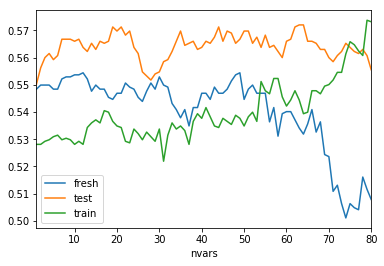

In [258]:
acc_trad.pivot_table(index="nvars").drop(["exp", "iter"], axis=1).plot()

In [259]:
iter_end_fmask

[['lag_51'],
 ['lag_51', 'lag_81'],
 ['lag_51', 'lag_81', 'lag_121'],
 ['lag_51', 'lag_81', 'lag_121', 'lag_87'],
 ['lag_51', 'lag_81', 'lag_121', 'lag_87', 'lag_14'],
 ['lag_51', 'lag_81', 'lag_121', 'lag_87', 'lag_14', 'lag_21'],
 ['lag_51', 'lag_81', 'lag_121', 'lag_87', 'lag_14', 'lag_21', 'lag_75'],
 ['lag_51',
  'lag_81',
  'lag_121',
  'lag_87',
  'lag_14',
  'lag_21',
  'lag_75',
  'lag_90'],
 ['lag_51',
  'lag_81',
  'lag_121',
  'lag_87',
  'lag_14',
  'lag_21',
  'lag_75',
  'lag_90',
  'lag_8'],
 ['lag_51',
  'lag_81',
  'lag_121',
  'lag_87',
  'lag_14',
  'lag_21',
  'lag_75',
  'lag_90',
  'lag_8',
  'lag_47'],
 ['lag_51',
  'lag_81',
  'lag_121',
  'lag_87',
  'lag_14',
  'lag_21',
  'lag_75',
  'lag_90',
  'lag_8',
  'lag_47',
  'lag_78'],
 ['lag_51',
  'lag_81',
  'lag_121',
  'lag_87',
  'lag_14',
  'lag_21',
  'lag_75',
  'lag_90',
  'lag_8',
  'lag_47',
  'lag_78',
  'lag_124'],
 ['lag_51',
  'lag_81',
  'lag_121',
  'lag_87',
  'lag_14',
  'lag_21',
  'lag_75',
  

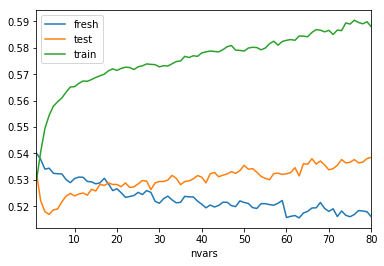

In [260]:
acc_thresh.pivot_table(index="nvars").drop(["exp", "iter"], axis=1).plot()

In [261]:
thresh_iter_end_fmask

[['lag_85'],
 ['lag_85', 'lag_89'],
 ['lag_85', 'lag_89', 'lag_103'],
 ['lag_85', 'lag_89', 'lag_103', 'lag_7'],
 ['lag_85', 'lag_89', 'lag_103', 'lag_7', 'lag_121'],
 ['lag_85', 'lag_89', 'lag_103', 'lag_7', 'lag_121', 'lag_49'],
 ['lag_85', 'lag_89', 'lag_103', 'lag_7', 'lag_121', 'lag_49', 'lag_122'],
 ['lag_85',
  'lag_89',
  'lag_103',
  'lag_7',
  'lag_121',
  'lag_49',
  'lag_122',
  'lag_20'],
 ['lag_85',
  'lag_89',
  'lag_103',
  'lag_7',
  'lag_121',
  'lag_49',
  'lag_122',
  'lag_20',
  'lag_24'],
 ['lag_85',
  'lag_89',
  'lag_103',
  'lag_7',
  'lag_121',
  'lag_49',
  'lag_122',
  'lag_20',
  'lag_24',
  'lag_47'],
 ['lag_85',
  'lag_89',
  'lag_103',
  'lag_7',
  'lag_121',
  'lag_49',
  'lag_122',
  'lag_20',
  'lag_24',
  'lag_47',
  'lag_69'],
 ['lag_85',
  'lag_89',
  'lag_103',
  'lag_7',
  'lag_121',
  'lag_49',
  'lag_122',
  'lag_20',
  'lag_24',
  'lag_47',
  'lag_69',
  'lag_9'],
 ['lag_85',
  'lag_89',
  'lag_103',
  'lag_7',
  'lag_121',
  'lag_49',
  'lag_

# Applying it to real data - Lots of Parameters

## Parameters

In [230]:
data_path = "SPX Index.csv" # data path
lags = 63 # number of lags to be considered
hold = 0.30 # holdout ratio
fresh = 0.30 # fresh ratio
ml_model = "nnet" # "sp_logistic"
#ml_param = [10.0**(-4.0), 10.0**(-3.0), 10.0**(-2.0), 10.0**(-1.0), 10.0**(-0.0), 10.0**(1.0), 2.0, 3.0, 5.0, 10.0, 20.0] 
ml_param = list(range(1, 100)[::5])
num_exp = 10 # number of experiments
T = 0.04 # Thresholdout parameter
tolerance = 0.01 # std gaussian noise
gen_error = 0.1 # generalisation error spread
B = int(gen_error*n) # budget - http://andyljones.tumblr.com/post/127547085623/holdout-reuse

## Simulation

In [231]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# pre-allocation
acc_trad = pd.DataFrame(index=[0], columns=["iter", "exp", "train", "test", "fresh"])
acc_thresh = pd.DataFrame(index=[0], columns=["iter", "exp", "train", "test", "fresh"])

# initial data to train, test and fresh
df = pd.read_csv(data_path, index_col=0)
df = ts2df(df, lags)
df.loc[df["lag_0"] > 0, "lag_0"] = 1.0
df.loc[df["lag_0"] <= 0, "lag_0"] = -1.0
df_tr = df.iloc[:(len(df)-int(len(df)*(fresh+hold)))]
df_ts = df.iloc[(len(df)-int(len(df)*(fresh+hold))):(len(df)-int(len(df)*fresh))]
df_fresh = df.iloc[(len(df)-int(len(df)*fresh)):]

# classification for every feature set
g, u = 0, 0
for exp in range(num_exp):
       
    # traditional and blind approach
    test_acc = []
    for k in ml_param: # number of iterations for feature selection

        # train model
        if ml_model == "sp_logistic":
            ml = LogisticRegression(C=k).fit(df_tr.drop("lag_0", axis=1), df_tr["lag_0"])
        elif ml_model == "nnet": 
            ml = MLPClassifier(hidden_layer_sizes=k, activation="relu").fit(df_tr.drop("lag_0", axis=1), df_tr["lag_0"])

        # prediction and accuracy
        test_acc.append((ml.predict(df_ts.drop("lag_0", axis=1))==df_ts["lag_0"]).mean())
                    
    # final prediction and accuracy
    best_param = ml_param[np.argmax(np.array(test_acc))]
    if ml_model == "sp_logistic":
        ml = LogisticRegression(C=best_param).fit(df_tr.drop("lag_0", axis=1), df_tr["lag_0"])
    elif ml_model == "nnet":
        ml = MLPClassifier(hidden_layer_sizes=best_param).fit(df_tr.drop("lag_0", axis=1), df_tr["lag_0"])
                               
    pred_tr = ml.predict(df_tr.drop("lag_0", axis=1))
    pred_ts = ml.predict(df_ts.drop("lag_0", axis=1))
    pred_fresh = ml.predict(df_fresh.drop("lag_0", axis=1))

    # evalute the classifier in the different sets
    acc_trad.loc[g, "param"] = best_param
    acc_trad.loc[g, "train"] = (pred_tr==df_tr["lag_0"]).mean()
    acc_trad.loc[g, "test"] = (pred_ts==df_ts["lag_0"]).mean()
    acc_trad.loc[g, "fresh"] = (pred_fresh==df_fresh["lag_0"]).mean()
    acc_trad.loc[g, "exp"]  = exp
    g+=1
        
    
    # thresholdout
    #thresh_iter_end_fmask, end_fmask, iter_fmask, fset = [], [], [], list(df.drop("lag_0", axis=1).columns)
    #for k in range(iterations): # number of iterations for feature selection

        # variable set
    #    test_acc = []
    #    for f in fset:
            
            # train model
    #        iter_fmask = end_fmask + [f]
    #        ml = LogisticRegression(C=10000.0).fit(df_tr[iter_fmask], df_tr["lag_0"])

            # prediction and accuracy
    #        tr_acc = (ml.predict(df_tr[iter_fmask])==df_tr["lag_0"]).mean()
    #        ts_acc = (ml.predict(df_ts[iter_fmask])==df_ts["lag_0"]).mean()
            
            # thresholdout criteria
    #        if abs(tr_acc-ts_acc) < T + np.random.normal(0, tolerance):
    #            ts_acc = tr_acc
    #        else:
    #            ts_acc += np.random.normal(0,tolerance)
    #        test_acc.append(ts_acc)
            
        # pick best feature test set
    #    end_fmask = end_fmask + [fset[np.argmax(np.array(test_acc))]]
    #    fset.remove(fset[np.argmax(np.array(test_acc))])
        
        # final prediction and accuracy
        #ml = LogisticRegression(C=10000.0).fit(df_tr[end_fmask], df_tr["lag_0"])
        #pred_tr = ml.predict(df_tr[end_fmask])
        #pred_ts = ml.predict(df_ts[end_fmask])
        #pred_fresh = ml.predict(df_fresh[end_fmask])

        # evalute the classifier in the different sets
        #acc_thresh.loc[u, "iter"] = k
        #acc_thresh.loc[u, "nvars"] = len(end_fmask)
        #acc_thresh.loc[u, "train"] = (pred_tr==df_tr["lag_0"]).mean()
        #acc_thresh.loc[u, "test"] = (pred_ts==df_ts["lag_0"]).mean()
        #acc_thresh.loc[u, "fresh"] = (pred_fresh==df_fresh["lag_0"]).mean()
        #acc_thresh.loc[u, "exp"]  = exp
        #thresh_iter_end_fmask.append(end_fmask)
        #u+=1
        
# final organisation
#acc_thresh = acc_thresh.apply(pd.to_numeric, errors='ignore', axis=1)
acc_trad = acc_trad.apply(pd.to_numeric, errors='ignore', axis=1)

C:\Users\Koshiyama\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Charts

In [232]:
acc_trad

,iter,exp,train,test,fresh,param
0,NaN,0.0,0.541574,0.547337,0.548077,91.0
1,NaN,1.0,0.521064,0.536982,0.545858,96.0
2,NaN,2.0,0.545455,0.536243,0.540680,36.0
3,NaN,3.0,0.549889,0.536243,0.545118,81.0
4,NaN,4.0,0.518847,0.538462,0.545858,6.0
5,NaN,5.0,0.518847,0.537722,0.545858,91.0
6,NaN,6.0,0.539357,0.550296,0.546598,96.0
7,NaN,7.0,0.518293,0.536243,0.545858,96.0
8,NaN,8.0,0.519956,0.538462,0.545858,56.0
9,NaN,9.0,0.518847,0.539201,0.545858,6.0


# Applying it to real data - Combining it with BO - TS

## Parameters

In [286]:
data_path = "SPX Index.csv" # data path
lags = 63 # number of lags to be considered
hold = 0.30 # holdout ratio
fresh = 0.30 # fresh ratio
num_exp = 1 # number of experiments
T = 0.04 # Thresholdout parameter
tolerance = 0.01 # std gaussian noise
hyperparams = {"C": [0.0001, 10.0], "gamma": [1.0/100, 1.0]}
bo_params = {"init_points": 10, "num_iter": 50}

## Simulation

In [287]:
from bayes_opt import BayesianOptimization
from sklearn.svm import SVC

# objective function
def obj_func(**hyper):

    # train model
    ml = SVC(C=hyper["C"], gamma=hyper["gamma"], kernel="rbf").fit(df_tr.drop("lag_0", axis=1), df_tr["lag_0"])

    # compute performance
    return (ml.predict(df_ts.drop("lag_0", axis=1))==df_ts["lag_0"]).mean()

# pre-allocation
acc_trad = pd.DataFrame(index=[0], columns=["exp", "train", "test", "fresh"])
acc_thresh = pd.DataFrame(index=[0], columns=["exp", "train", "test", "fresh"])

# initial data to train, test and fresh
df = pd.read_csv(data_path, index_col=0)
df = ts2df(df, lags)
df.loc[df["lag_0"] > 0, "lag_0"] = 1.0
df.loc[df["lag_0"] <= 0, "lag_0"] = -1.0
df_tr = df.iloc[:(len(df)-int(len(df)*(fresh+hold)))]
df_ts = df.iloc[(len(df)-int(len(df)*(fresh+hold))):(len(df)-int(len(df)*fresh))]
df_fresh = df.iloc[(len(df)-int(len(df)*fresh)):]

# classification for every feature set
g, u = 0, 0
for exp in range(num_exp):
       
    # traditional and blind approach
    bo_model = BayesianOptimization(obj_func, hyperparams)#, verbose=0)
    bo_model.maximize(init_points=bo_params["init_points"], n_iter=bo_params["num_iter"])
    
    # get best params and train model
    model_results = pd.DataFrame(bo_model.X, columns=list(hyperparams.keys()))
    model_results["acc"] = bo_model.Y
    opt_hyper = model_results.iloc[model_results["acc"].idxmax()].to_dict()
    ml = SVC(C=opt_hyper["C"], gamma=opt_hyper["gamma"], kernel="rbf").fit(df_tr.drop("lag_0", axis=1), df_tr["lag_0"])
                        
    # final prediction and accuracy
    pred_tr = ml.predict(df_tr.drop("lag_0", axis=1))
    pred_ts = ml.predict(df_ts.drop("lag_0", axis=1))
    pred_fresh = ml.predict(df_fresh.drop("lag_0", axis=1))

    # evalute the classifier in the different sets
    acc_trad.loc[g, "train"] = (pred_tr==df_tr["lag_0"]).mean()
    acc_trad.loc[g, "test"] = (pred_ts==df_ts["lag_0"]).mean()
    acc_trad.loc[g, "fresh"] = (pred_fresh==df_fresh["lag_0"]).mean()
    acc_trad.loc[g, "exp"]  = exp
    g+=1
        
# final organisation
acc_trad = acc_trad.apply(pd.to_numeric, errors='ignore', axis=1)

ValueError: Length mismatch: Expected axis has 7104 elements, new values have 64 elements

## Charts

In [280]:
acc_trad

,exp,train,test,fresh
0,0.0,0.546563,0.552515,0.547337


# Trash

# Extending Paper Results to Other Models

## Parameters

In [198]:
# data parameters
n = 10000 # number of samples
d = 1000 # number of available features
p1 = 0.5 # frequency class 1

# experiment parameters
h = 0.5 # holdout ratio
num_exp = 3 # number of experiments
T = 0.04 # Thresholdout parameter
gnoise = 0.01 # std gaussian noise

# model parameters
ml_model = "random" # "adaboost" # "dec_tree" # "sp_logistic"
#ml_param = [10.0**(-4.0), 10.0**(-3.0), 10.0**(-2.0), 10.0**(-1.0), 10.0**(-0.0), 10.0**(1.0)]
#ml_param = [1, 2, 3, 4, 5, 6, 7]
#ml_param = [10, 20, 30, 50, 70, 90, 100, 120, 150, 200, 250]
ml_param = range(100)

## Simulation

In [203]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.dummy import DummyClassifier

# pre-allocation
acc_trad = pd.DataFrame(index=range(len(ml_param)), columns=["param", "train", "test"])
best_param = pd.DataFrame(index = range(num_exp), columns=["exp", "best_param", "test", "fresh"])

# initial data
df = pd.DataFrame(np.random.normal(size=(n, d)))
df["out"] = 1.0
df.loc[:int(n*p1), "out"] = 1.0
df.loc[int(n*p1):, "out"] = -1.0
df = df.sample(n=n).copy()
df.index = list(range(n))

# split in training and test
df = df.sample(n=n).copy()
df.index = list(range(n))
df_tr = df.loc[:int(n*h)].copy()
df_ts = df.loc[int(n*h):].copy()
df_ts.index = list(range(len(df_ts)))

# fresh data
df_fresh = pd.DataFrame(np.random.normal(size=(int(n*h), d)))
df_fresh["out"] = 1.0
df_fresh.loc[:int(n*p1), "out"] = 1.0
df_fresh.loc[int(n*p1):, "out"] = -1.0
df_fresh = df_fresh.sample(n=int(n*h)).copy()
df_fresh.index = list(range(int(n*h)))

# classification for every feature set
for exp in range(num_exp):
    g=0
    # construct the classifier
    for param in ml_param:
        if ml_model == "sp_logistic":
            ml = LogisticRegression(C=param).fit(df_tr.drop("out", axis=1), df_tr["out"])
        elif ml_model == "dec_tree":
            ml = DecisionTreeClassifier(max_depth=param).fit(df_tr.drop("out", axis=1), df_tr["out"])
        elif ml_model == "adaboost":
            ml = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=param).fit(df_tr.drop("out", axis=1), df_tr["out"])
        elif ml_model == "random":
            ml = DummyClassifier(strategy="uniform").fit(df_tr.drop("out", axis=1), df_tr["out"])
        
        pred_tr = ml.predict(df_tr.drop("out", axis=1))
        pred_ts = ml.predict(df_ts.drop("out", axis=1))

        # evalute the classifier in the different sets
        acc_trad.loc[g, "param"] = param
        acc_trad.loc[g, "train"] = (pred_tr==df_tr["out"]).mean()
        acc_trad.loc[g, "test"] = (pred_ts==df_ts["out"]).mean()
        g+=1
    
    best_param.loc[exp, "exp"] = exp
    best_param.loc[exp, "best_param"] = acc_trad.loc[acc_trad.loc[(g-len(ml_param)):, "test"].idxmax(), "param"]
    best_param.loc[exp, "test"] = acc_trad.loc[(g-len(ml_param)):, "test"].max()
    ml = LogisticRegression(C=best_param.loc[exp, "best_param"]).fit(df.drop("out", axis=1), df["out"])
    pred_fresh = ml.predict(df_fresh.drop("out", axis=1))
    best_param.loc[exp, "fresh"] = (pred_fresh==df_fresh["out"]).mean()

acc_trad = acc_trad.apply(pd.to_numeric, errors='ignore', axis=1)
best_param = best_param.apply(pd.to_numeric, errors='ignore', axis=1)

## Charts

In [204]:
acc_trad

,param,train,test
0,0.0,0.490902,0.5000
1,1.0,0.510498,0.5014
2,2.0,0.499300,0.5106
3,3.0,0.504899,0.4972
4,4.0,0.507099,0.5108
5,5.0,0.513297,0.5012
6,6.0,0.497101,0.5066
7,7.0,0.501500,0.5008
8,8.0,0.500900,0.5004
9,9.0,0.516897,0.5062


In [205]:
best_param

,exp,best_param,test,fresh
0,0.0,51.0,0.5162,0.506
1,1.0,89.0,0.5134,0.506
2,2.0,41.0,0.5192,0.506


In [ ]:
        # thresholdout
        That = T + np.random.normal(scale=gnoise*2.0)
        eta = np.random.normal(scale=gnoise*4.0)
        if abs(acc_trad.loc[g, "test"] - acc_trad.loc[g, "train"]) > (That + eta):
            xi = np.random.normal(scale=gnoise)
            acc_trad.loc[g, "thresh"] = acc_trad.loc[g, "test"] + xi
        else:
            acc_trad.loc[g, "thresh"] = acc_trad.loc[g, "train"]